# Auto Insurance dataset

## Model selection and classification

In this notebook, we will test different models for the prediction of the target binary class on the auto insurance dataset produced for this 2017 [Kaggle challenge](https://www.kaggle.com/c/auto-insurance-fall-2017).

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from time import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from utilities import *

np.set_printoptions(precision=3, suppress=True)

sns.set_theme(
    context='talk',
    style='whitegrid',
    palette='pastel'
)
plt.rcParams["figure.figsize"] = (16,9)

### Data import and preprocessing

After having imported the data, we perform the same pre-processing that we have discussed in the Exploration notebook to obtain the cleaned dataframe.

In [2]:
dataset_raw = pd.read_csv('data/auto-insurance-fall-2017/train_auto.csv',
                          true_values=['yes', 'Yes', 'YES'],
                          false_values=['no', 'No', 'NO', 'z_No'],
                          index_col='INDEX'
                         )

# DROP UNUSED COLUMNS
train = dataset_raw.drop(columns="TARGET_AMT")

# SELECT LABEL
labels = train.pop('TARGET_FLAG').astype('bool').to_numpy()

# CLEAN STRINGS
train = train.apply(lambda x: x.str.replace('z_', '') if x.dtype == object else x)

# RATIONALISE TYPES
train = train.convert_dtypes()

# CLEAN MONEY COLUMNS
money_cols = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]
train = clean_money_columns(train, money_cols, log=True, scale=False, indicator=True)

# CATEGORICAL COLUMNS WITH NUMERICAL VALUES
categoricals = ["KIDSDRIV", "HOMEKIDS", "CLM_FREQ"]
for col in categoricals:
    train[col] = train[col].astype(str)

# ENFORCE TYPE CONSISTENCY
train = clean_types(train, verbose=False)

sample_size, n_features = train.shape

# Number of splits for CV 
# my laptop allows to run 8 simultaneous threads
n_splits = 16

print(f"{'Sample size':<20}: {sample_size:<6}")
print(f"{'N of folds for CV':<20}: {n_splits:<6}")
print(f"{'Samples per fold':<20}: {sample_size // n_splits}")
print(f"{'N of features':<20}: {n_features:<6}")
print(f"{'Positive examples':<20}: {100. * sum(labels) / sample_size:.1f} %")

Sample size         : 8161  
N of folds for CV   : 16    
Samples per fold    : 510
N of features       : 27    
Positive examples   : 26.4 %


Now we use the One Hot Encoding to produce a dataset viable to be fed into our models and we transform all the columns in floating point values.

In [3]:
cols = []

for name, column in train.items():
    if column.dtype == 'category':
        ohe = OneHotEncoder(drop='if_binary', sparse=False)
        cols.append(ohe.fit_transform(column.cat.codes.to_numpy(dtype=np.float64).reshape(-1, 1)))
    elif column.dtype == 'boolean':
        cols.append(column.to_numpy(dtype=np.float64, na_value=-1).reshape(-1, 1))
    else:
        cols.append(column.to_numpy(dtype=np.float64, na_value=np.nan).reshape(-1, 1))

train = np.concatenate(cols, axis=-1)
print(train.shape)

(8161, 58)


### Model selection

#### Choice of the metric

To choose the metric, we need to consider that this dataset, although not extremely so, is unbalanced: there are many more negative samples than positive ones.

If we used the *Accuracy* metric (as is customary with classification tasks), we might incur the problem of pushing the classifier toward negatively classifying most of the samples, as it is generally rewarded for doing so. Indeed, we are interested in using more significant metrics for our task, such as *Precision*, *Recall*, and the *F1 score*. 

Rapidly, the four metrics discussed here are

$$
    P = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} \qquad R = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

$$
    F1 = 2 * \frac{P \cdot R}{P + R} \qquad A = \frac{\text{Correct prediction}}{\text{All dataset}}
$$

In our context, it might seem reasonable that *Recall* should hold more weight in the decision process, as it might seem that we would really want to not miss true positive cases, even at the cost of slightly increasing the false positive rate. Our classifiers, during the exploration phase, will compute all four of this metrics to provide better insight on the classification procedure (indeed, the *Accuracy* even if it is not indicated on imbalanced problems might work as a sanity check).

In [4]:
metrics = ['accuracy', 'f1', 'precision', 'recall']

#### Choice of the estimator

As estimators, we start from the three staples of classification problems for small datasets, *i.e.* the Random Forest of Decision Trees, the Gradient Boosted Decision Tree, and the Support Vector Machine. We use the `scikit-learn` implementations for these algorithms, choosing the linear kernel for the SVM algorithm (for simplicity) and trying both the standard Gradient Boosting algorithm with subsampling from [Friedman (2002)](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf) and its histogram-based version, similar to [LightGBM](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree).

In [5]:
estimators = {
    'RF': RandomForestClassifier(
        n_estimators=150,
        max_features='sqrt',
        oob_score=True,
        class_weight='balanced',
        max_samples=0.8
    ),
    'GB': GradientBoostingClassifier(
        n_estimators=150,
        loss='deviance',
        learning_rate=0.1,
        subsample=0.8,
        max_features='sqrt'
    ),
    'HGB': HistGradientBoostingClassifier(
        max_iter=100,
        learning_rate=0.1
    ),
    'SVM': LinearSVC(
        dual=False,
        fit_intercept=False,
        class_weight='balanced'
    )
}

#### Choice of the imputer

We test 3 different imputers (plus "one", as the histogram-based implementation of the GBDT has a built-in way to deal with missing values) to deal with the missing values.

The first two imputers replace the missing value with a fixed number ($0$ in one case and the column median in the other). Notice that, as we will apply the imputer after the standardization, using $0$ as the filling value is equivalent to using the mean.

The last imputer, instead, computes the missing values employing a K-Nearest Neighbor algorithm along all the other dimensions.

All the imputers then add a column to indicate where the missing values were, in order to preserve the information in the event that it might add some value.

In [6]:
imputers = {
    'Nothing': None,
    '0': SimpleImputer(
        missing_values=np.nan,
        add_indicator=True,
        strategy='constant',
        fill_value=-1
    ),
    'Median': SimpleImputer(
        missing_values=np.nan,
        add_indicator=True, 
        strategy="median", 
    ),
    'KNN': KNNImputer(
        missing_values=np.nan,
        add_indicator=True
    )
}

#### Cross validation

To choose between the various estimators and the various imputers, we perform a cross validation by splitting the data in 16 parts. This way each test set has around 510 samples (which should contain enough positive examples to still be valid) and each classifier has enough data for the training. Moreover, by performing more splits we reduce the variance on the values of the metrics, allowing for a more sensible discussion.

In [7]:
def get_crossvalidation_score(estimator, imputer, X, y):
    scaler = StandardScaler()
    if imputer is None:
        model = make_pipeline(scaler, estimator)
    else:
        model = make_pipeline(scaler, imputer, estimator)
    score = cross_validate(model, X, y, 
                           scoring=metrics, 
                           cv=n_splits, 
                           n_jobs=-1, 
                           return_train_score=True, 
                           return_estimator=True
                          )
    return score

In [8]:
scores = []
fitted_estimators = []
print(f"{'ESTIMATOR':<9}  |  {'IMPUTER':<7}  |  {'Time':<6}  |  {'Acc':<5}  |  {'F1':<5}  |  {'Prec':<5}  |  {'Rec':<5}")
print("="*(9 + 7 + 6 + 5 * 4 + 5 * 6))
for estimator_name, estimator in estimators.items():
    for imputer_name, imputer in imputers.items():
        if (imputer_name == 'Nothing') and (estimator_name != 'LGB'):
            pass
        else:
            tic = time()
            print(f"{estimator_name:<9}  |  {imputer_name:<7}", end='')
            score = get_crossvalidation_score(estimator, imputer, train, labels)
            toc = time()
            print(f"  |  {f'{toc - tic:.3f}':<6}", end='')
            for k, val in score.items():
                if k[:5] == 'test_':
                    print(f"  |  {val.mean():.3f}", end='')
            print("")
            fitted_estimators.append(score['estimator'])
            score['estimator'] = [estimator_name] * n_splits
            score['imputer'] = [imputer_name] * n_splits
            score['total_time'] = [toc - tic] * n_splits
            scores.append(score)

ESTIMATOR  |  IMPUTER  |  Time    |  Acc    |  F1     |  Prec   |  Rec  
RF         |  0        |  7.938   |  0.785  |  0.430  |  0.718  |  0.308
RF         |  Median   |  6.352   |  0.786  |  0.435  |  0.724  |  0.313
RF         |  KNN      |  26.802  |  0.786  |  0.438  |  0.720  |  0.316
GB         |  0        |  5.060   |  0.797  |  0.527  |  0.687  |  0.428
GB         |  Median   |  3.713   |  0.795  |  0.519  |  0.682  |  0.419
GB         |  KNN      |  18.412  |  0.797  |  0.528  |  0.686  |  0.430
HGB        |  0        |  4.970   |  0.797  |  0.551  |  0.662  |  0.473
HGB        |  Median   |  5.156   |  0.795  |  0.544  |  0.658  |  0.465
HGB        |  KNN      |  20.529  |  0.797  |  0.548  |  0.667  |  0.466
SVM        |  0        |  2.570   |  0.718  |  0.588  |  0.478  |  0.763
SVM        |  Median   |  2.374   |  0.719  |  0.588  |  0.479  |  0.762
SVM        |  KNN      |  17.686  |  0.708  |  0.583  |  0.469  |  0.771


### Results
We can see the average of the resulting metrics computed on the train and test set on each fold, divided by estimators and imputer. 

In [9]:
results = pd.concat([pd.DataFrame(x) for x in scores])
results.set_index(['estimator', 'imputer'], inplace=True)
results.groupby(['estimator', 'imputer']).mean()

fit_time  score_time  test_accuracy  train_accuracy  \
estimator imputer                                                        
GB        0        2.234417    0.015341       0.797333        0.818396   
          KNN      4.872082    0.278484       0.797455        0.818225   
          Median   1.600822    0.011447       0.794758        0.818388   
HGB       0        2.131814    0.019859       0.796841        0.899122   
          KNN      5.871666    0.310338       0.797332        0.898828   
          Median   2.217728    0.020260       0.794635        0.898615   
RF        0        2.571476    0.062718       0.785077        0.999714   
          KNN      7.739101    0.345096       0.786179        0.999657   
          Median   2.340595    0.059057       0.786178        0.999657   
SVM       0        1.145446    0.007595       0.717680        0.722305   
          KNN      4.701810    0.316584       0.708491        0.715786   
          Median   1.018260    0.006691       0.718538        0.723441   

                    test_f1  train_f1  test_precision  train_precision  \
estimator imputer                                                        
GB        0        0.526828  0.577975        0.687483         0.746881   
          KNN      0.528233  0.578131        0.686462         0.745507   
          Median   0.518566  0.578303        0.682380         0.746251   
HGB       0        0.550778  0.785380        0.661789         0.895085   
          KNN      0.547946  0.784843        0.667028         0.893961   
          Median   0.544250  0.784270        0.657733         0.893991   
RF        0        0.430373  0.999458        0.718479         1.000000   
          KNN      0.437708  0.999349        0.720052         1.000000   
          Median   0.434713  0.999349        0.723840         1.000000   
SVM       0        0.587665  0.593608        0.478428         0.483462   
          KNN      0.582769  0.591479        0.468608         0.476387   
          Median   0.588072  0.594051        0.479323         0.484741   

                   test_recall  train_recall  total_time  
estimator imputer                                         
GB        0           0.428331      0.471404    5.059880  
          KNN         0.429699      0.472178   18.412449  
          Median      0.419489      0.472116    3.712510  
HGB       0           0.472889      0.699675    4.970270  
          KNN         0.466397      0.699489   20.528889  
          Median      0.465468      0.698560    5.155611  
RF        0           0.308458      0.998916    7.937878  
          KNN         0.315875      0.998700   26.801736  
          Median      0.312631      0.998699    6.352460  
SVM       0           0.762655      0.768757    2.569890  
          KNN         0.771490      0.779904   17.685652  
          Median      0.761730      0.767023    2.373889

A more clear picture of what is happening can be obtained by plotting the metrics for each pair estimator-imputer.

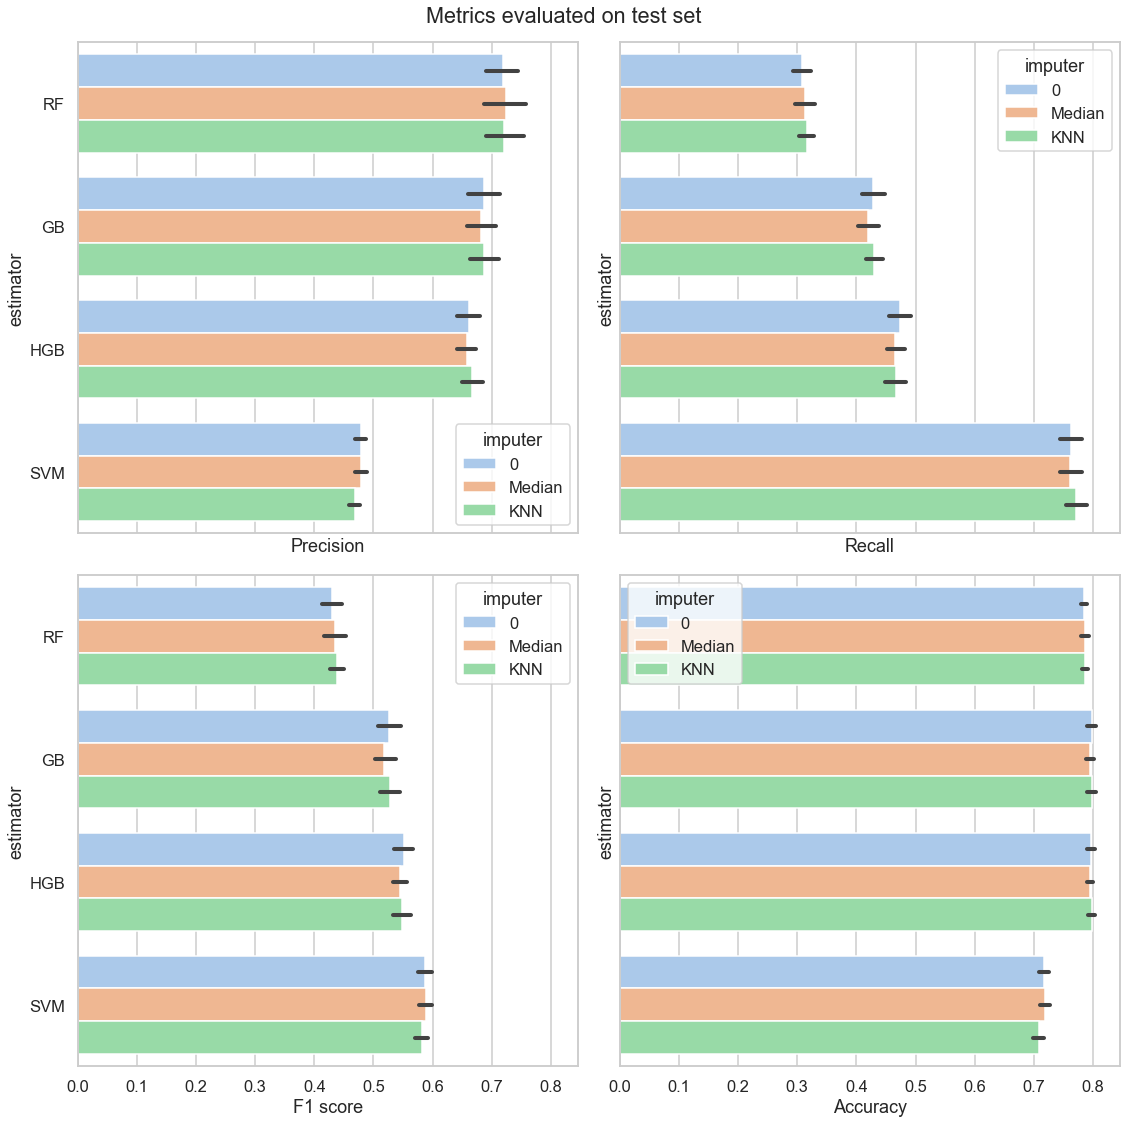

In [10]:
f, a = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 16))

sns.barplot(data=results.reset_index(), y='estimator', x='test_precision', hue='imputer', ax=a[0,0])
a[0,0].set_xlabel('Precision')
sns.barplot(data=results.reset_index(), y='estimator', x='test_recall', hue='imputer', ax=a[0,1])
a[0,1].set_xlabel('Recall')

sns.barplot(data=results.reset_index(), y='estimator', x='test_f1', hue='imputer', ax=a[1,0])
a[1,0].set_xlabel("F1 score")
sns.barplot(data=results.reset_index(), y='estimator', x='test_accuracy', hue='imputer', ax=a[1,1])
a[1,1].set_xlabel("Accuracy")

plt.suptitle('Metrics evaluated on test set')
plt.tight_layout()
plt.show();

#### Comments on the results

As clear from the plots, the used imputer does not really impact *significantly* the metrics of interest. This is due to the small number of missing values that were present in the first place, but this reassures us and we are then allowed to choose whatever technique we prefer, so we will use the `MedianImputer`.

Regarding the choice of the classifier, we see that the three algorithms exhibit very different behaviours: the Random Forest shows the highest *Precision* but with a very low *Recall*, while the SVM has the opposite performances. The two versions of Gradient Boosting, instead, thread in the middle, with the histogram-based having slightly higher *Recall*.

As we discussed before, the most interesting score to watch in our scenario would be the *F1* score, but with a more rewarding eye toward the classifier that achieves the highest *Recall*. If we were to look at the first three plots, then, we would choose the SVM classifier. 

Luckily we decided to show also the *Accuracy* of each classifier, which is a staple for classification problems but not really adapt when dealing with an imbalanced dataset, works in this case as a sanity check: the SVM classifier has the smallest accuracy of all the dataset by a significant margin (around 8-9%), which tells us that it is pushing much more positive examples than it should. Thus, we exclude the SVM from our analysis.

The remaining 3 classifiers have pretty similar *F1* score, with the two Gradient Boosting flavours having a confortable margin over the Random Forest. As the choice is then between these two, we reward the histogram-based Gradient Boosting algorithm for its slightly higher *Recall*.

In a real scenario, as the performances of both algorithms are very similar, we would need to do some fine-tuning of the hyperparameters before deciding in one sense or the other. Anyway, the results that we got from this quick exploration confirm the common knowledge that the family of GradientBoosting methods is generally the best technique for an off-the-shelf estimation when the dataset is small to medium size.

### Full training and prediction
Having made the choice of the estimator and the imputer, we train the model with the full dataset to perform a prediction on the test dataset.

In [11]:
scaler = StandardScaler()
imputer = SimpleImputer(
    missing_values=np.nan,
    add_indicator=True, 
    strategy="median", 
)
estimator = HistGradientBoostingClassifier(
        max_iter=100,
        learning_rate=0.1
    )


model = make_pipeline(scaler, imputer, estimator)

model.fit(train, labels)
labels_pred = model.predict(train)
print(f"Percentage of positive predicted samples: {100. * labels_pred.sum() / sample_size:.2f} %")

Percentage of positive predicted samples: 20.14 %


We then import and preprocess the test dataset, using the exact same procedure that we used for the training set.

In [12]:
test_raw = pd.read_csv('data/auto-insurance-fall-2017/test_auto.csv',
                          true_values=['yes', 'Yes', 'YES'],
                          false_values=['no', 'No', 'NO', 'z_No']
                         )
# DROP UNUSED COLUMNS
test = test_raw.drop(columns="TARGET_AMT")
y = test.pop('TARGET_FLAG').astype('bool').to_numpy()
test = test.apply(lambda x: x.str.replace('z_', '') if x.dtype == object else x)
test = test.convert_dtypes()

# CLEAN MONEY COLUMNS
money_cols = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]
test = clean_money_columns(test, money_cols, log=True, scale=False, indicator=True)

# CATEGORICAL COLUMNS WITH NUMERICAL VALUES
categoricals = ["KIDSDRIV", "HOMEKIDS", "CLM_FREQ"]
for col in categoricals:
    test[col] = test[col].astype(str)

# TYPE CONSISTENCY
test = clean_types(test, verbose=False)

test_size, n_features = test.shape
print(f"{'Test size':<20} : {test_size:<6}")
print(f"{'N of features':<20} : {n_features:<6}")

cols = []

for name, column in test.items():
    if column.dtype == 'category':
        ohe = OneHotEncoder(drop='if_binary', sparse=False)
        cols.append(ohe.fit_transform(column.cat.codes.to_numpy().reshape(-1, 1)))
    elif column.dtype == 'boolean':
        cols.append(column.to_numpy(dtype=np.float32, na_value=-1).reshape(-1, 1))
    else:
        cols.append(column.to_numpy(dtype=np.float32, na_value=np.nan).reshape(-1, 1))

test = np.concatenate(cols, axis=-1)
print(f"{'Readied test dataset':<20} : {test.shape[0]} x {test.shape[1]}")

Test size            : 2141  
N of features        : 28    
Readied test dataset : 2141 x 58


Finally, we perform the prediction on the test set, and we save the output in a csv file. We also print the percentage of samples that have a positive outcome on the test check to check if it is around the same as what we obtained in the train set.

In [15]:
y_pred = model.predict(test)
np.savetxt('data/auto-insurance-fall-2017/prediction_auto.csv', y_pred, fmt='%1d', delimiter=',', newline='\n')
print(f"Percentage of positive predicted samples: {100. * y_pred.sum() / test_size:.2f} %")

Percentage of positive predicted samples: 19.99 %
